# TP2 - Planejamento e Navegação de Caminhos com Pioneer P3DX (Robô Diferencial)

1. Graduação e Pós-graduação  
  b. **Campos Potenciais –  Robô Diferencial**

**Estudante**: Daniel Terra Gomes  
**Data**: Outubro 2025

---
Para essa primeira parte do notebook USE o CoppeliaSim Scene *mapas\paredes-PioneerP3DX.ttt*  utilizando o robô diferencial **Pioneer P3DX** e localização Goal no CoppeliaSim.

---

## 1. Setup e Imports

In [28]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import binary_dilation
import time

# Add utils to path
sys.path.append('./utils')

# Import custom modules
from pioneer_controller import PioneerController
from potential_fields_planner import PotentialFieldsPlanner
from common_utils import wait_for_user_input

## 2. Config


In [29]:
# World parameters
WORLD_WIDTH = 10.0    # Map size (m)

# Pioneer P3DX dimensions (differential drive robot)
ROBOT_RADIUS = 0.20   # meters
SAFETY_MARGIN = 0.15  # meters
EFFECTIVE_RADIUS = ROBOT_RADIUS + SAFETY_MARGIN  # 0.35m total for C-space

# Potential Fields parameters (tuned for sensor-based reactive navigation)
K_ATT = 5.0           # Attractive force gain
K_REP = 0.8           # Repulsive force gain (low for raw sensor data)
D0 = 1.2              # Obstacle influence distance (meters)
STEP_SIZE = 0.2       # Integration step size (meters)
MAX_ITERATIONS = 1000 # Maximum navigation iterations
GOAL_THRESHOLD = 0.5  # Goal reach threshold (meters)

MAX_LINEAR_VEL = 0.5  # Maximum linear velocity (m/s)
MAX_ANGULAR_VEL = 1.0 # Maximum angular velocity (rad/s)
CONTROL_RATE = 0.1    # Control loop period (s)

# Coordinate frame transformation functions
def sim_to_map(x, y, world_height):
    """Transform CoppeliaSim coordinates to map coordinates."""
    map_x = x + (WORLD_WIDTH / 2.0)
    map_y = y + (world_height / 2.0)
    return (map_x, map_y)

def map_to_sim(x, y, world_height):
    """Transform map coordinates to CoppeliaSim coordinates."""
    sim_x = x - (WORLD_WIDTH / 2.0)
    sim_y = y - (world_height / 2.0)
    return (sim_x, sim_y)

print(f"  Robot radius: {ROBOT_RADIUS:.3f} m")
print(f"  Safety margin: {SAFETY_MARGIN:.3f} m")
print(f"  Effective radius (C-space): {EFFECTIVE_RADIUS:.3f} m")
print(f"  Potential Fields: K_ATT={K_ATT}, K_REP={K_REP}, D0={D0}m")
print(f"  Control: v_max={MAX_LINEAR_VEL}m/s, omega_max={MAX_ANGULAR_VEL}rad/s")

  Robot radius: 0.200 m
  Safety margin: 0.150 m
  Effective radius (C-space): 0.350 m
  Potential Fields: K_ATT=5.0, K_REP=0.8, D0=1.2m
  Control: v_max=0.5m/s, omega_max=1.0rad/s


## 3. Conecta ao Coppeliam

In [30]:
controller = PioneerController()

# Connect to CoppeliaSim
if not controller.connect():
    raise Exception("Failed to connect to CoppeliaSim")

# Initialize scene
if not controller.initialize_scene():
    raise Exception("Failed to initialize scene")

print(f"  - Wheelbase: {controller.WHEEL_DISTANCE:.3f} m")
print(f"  - Wheel radius: {controller.WHEEL_RADIUS:.4f} m")

✓ Connected to CoppeliaSim
✓ Found robot: PioneerP3DX
✓ Found motors: leftMotor, rightMotor
✓ Initialized Hokuyo laser sensor
✓ Found goal at: (3.10, 2.40)
  - Wheelbase: 0.381 m
  - Wheel radius: 0.0975 m
✓ Found robot: PioneerP3DX
✓ Found motors: leftMotor, rightMotor
✓ Initialized Hokuyo laser sensor
✓ Found goal at: (3.10, 2.40)
  - Wheelbase: 0.381 m
  - Wheel radius: 0.0975 m


In [31]:
try:
    all_objects = controller.sim.getObjectsInTree(controller.sim.handle_scene, controller.sim.object_shape_type, 0)

    terrain_found = False
    for obj_handle in all_objects:
        try:
            obj_name = controller.sim.getObjectAlias(obj_handle)
            if 'terrain' in obj_name.lower() or 'heightfield' in obj_name.lower():
                min_x = controller.sim.getObjectFloatParam(obj_handle, controller.sim.objfloatparam_objbbox_min_x)
                max_x = controller.sim.getObjectFloatParam(obj_handle, controller.sim.objfloatparam_objbbox_max_x)
                min_y = controller.sim.getObjectFloatParam(obj_handle, controller.sim.objfloatparam_objbbox_min_y)
                max_y = controller.sim.getObjectFloatParam(obj_handle, controller.sim.objfloatparam_objbbox_max_y)

                terrain_width = max_x - min_x
                terrain_height = max_y - min_y

                print(f"Detected {obj_name}: {terrain_width:.2f}m × {terrain_height:.2f}m")
                terrain_found = True
                break
        except:
            continue

    if not terrain_found:
        terrain_width = 10.0
        terrain_height = 10.0
        print(f"No terrain detected, using default: {terrain_width:.2f}m × {terrain_height:.2f}m")

except Exception as e:
    terrain_width = 10.0
    terrain_height = 10.0
    print(f"Error detecting terrain: {e}")
    print(f"   Using default: {terrain_width:.2f}m × {terrain_height:.2f}m")

# Store actual terrain dimensions
ACTUAL_TERRAIN_WIDTH = terrain_width
ACTUAL_TERRAIN_HEIGHT = terrain_height

# Get robot pose
robot_x, robot_y, robot_theta = controller.get_robot_pose_2d()
robot_map_x, robot_map_y = sim_to_map(robot_x, robot_y, ACTUAL_TERRAIN_HEIGHT)

print(f"   Position (CoppeliaSim): ({robot_x:.2f}, {robot_y:.2f})")
print(f"   Orientation: {np.degrees(robot_theta):.1f}°")
print(f"   Position (Map frame): ({robot_map_x:.2f}, {robot_map_y:.2f})")

# Get goal position
goal_pos = controller.get_goal_position()
if goal_pos:
    goal_map_x, goal_map_y = sim_to_map(goal_pos[0], goal_pos[1], ACTUAL_TERRAIN_HEIGHT)
    print(f"   Position (CoppeliaSim): ({goal_pos[0]:.2f}, {goal_pos[1]:.2f})")
    print(f"   Position (Map frame): ({goal_map_x:.2f}, {goal_map_y:.2f})")
else:
    raise Exception("Goal not found in scene!")

Detected Terrain_Heightfield: 10.00m × 7.67m
   Position (CoppeliaSim): (2.67, -1.32)
   Orientation: 90.0°
   Position (Map frame): (7.67, 2.51)
   Position (CoppeliaSim): (3.10, 2.40)
   Position (Map frame): (8.10, 6.24)


## 4. Carrega mapa png

    Paredes Map loaded: (500, 650) pixels
  - Physical size: 10.0m x 7.7m
  - C-space dilation: 22 pixels (0.350m)


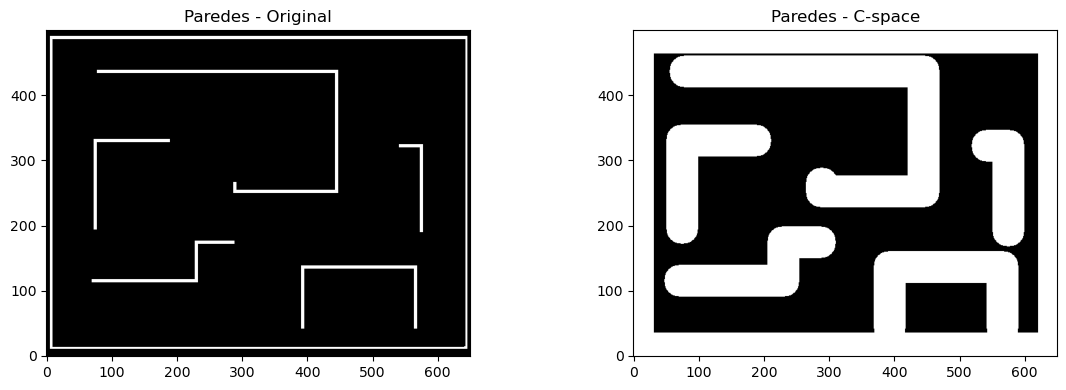

In [32]:
map_path_1 = "mapas/paredes.png"
mapa_img_1 = Image.open(map_path_1).convert('L')
mapa_raw_1 = np.array(mapa_img_1)

# Normalize: 0=free, 1=obstacle
mapa_original_1 = 1.0 - (mapa_raw_1 / 255.0)

# Apply C-space transformation
radius_pixels_1 = int((EFFECTIVE_RADIUS / ACTUAL_TERRAIN_WIDTH) * mapa_original_1.shape[1])
y, x = np.ogrid[-radius_pixels_1:radius_pixels_1+1, -radius_pixels_1:radius_pixels_1+1]
structure_1 = (x**2 + y**2 <= radius_pixels_1**2).astype(int)
mapa_1 = binary_dilation(mapa_original_1 > 0.5, structure=structure_1).astype(float)

print(f"    Paredes Map loaded: {mapa_1.shape} pixels")
print(f"  - Physical size: {ACTUAL_TERRAIN_WIDTH:.1f}m x {ACTUAL_TERRAIN_HEIGHT:.1f}m")
print(f"  - C-space dilation: {radius_pixels_1} pixels ({EFFECTIVE_RADIUS:.3f}m)")

# Visualize
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(mapa_original_1, cmap='gray', origin='lower')
plt.title('Paredes - Original')
plt.subplot(1, 2, 2)
plt.imshow(mapa_1, cmap='gray', origin='lower')
plt.title('Paredes - C-space')
plt.tight_layout()
plt.show()

## 5. "Planeja" caminho

In [33]:
# Initialize planner
planner_1 = PotentialFieldsPlanner(
    mapa=mapa_1,
    world_width=ACTUAL_TERRAIN_WIDTH,
    world_height=ACTUAL_TERRAIN_HEIGHT,
    k_att=K_ATT,
    k_rep=K_REP,
    d0=D0
)

# Define start and goal
start_map_1 = (robot_map_x, robot_map_y)
goal_map_1 = (goal_map_x, goal_map_y)

print(f"Start: ({start_map_1[0]:.2f}, {start_map_1[1]:.2f})")
print(f"Goal:  ({goal_map_1[0]:.2f}, {goal_map_1[1]:.2f})")
print(f"Parameters: k_att={K_ATT}, k_rep={K_REP}, d0={D0}m")
print(f"\nNote: Using REACTIVE navigation (forces computed in real-time)")

# For visualization purposes only, try to generate an approximate trajectory
# This is NOT used for execution - just for showing the general path
print(f"\nGenerating approximate trajectory for visualization...")
start_time_1 = time.time()

trajectory_1 = planner_1.navigate(
    start=start_map_1,
    goal=goal_map_1,
    max_iterations=MAX_ITERATIONS,
    step_size=STEP_SIZE,
    goal_threshold=GOAL_THRESHOLD
)

elapsed_time_1 = time.time() - start_time_1

if trajectory_1 and len(trajectory_1) > 1:
    path_array_1 = np.array(trajectory_1)
    path_length_1 = np.sum(np.sqrt(np.sum(np.diff(path_array_1, axis=0)**2, axis=1)))

    distance_to_goal = np.linalg.norm(path_array_1[-1] - np.array(goal_map_1))

    if distance_to_goal < GOAL_THRESHOLD:
        print(f"   Approximate path generated!")
        print(f"   Waypoints: {len(trajectory_1)}")
        print(f"   Path length: {path_length_1:.2f} m")
        print(f"   Planning time: {elapsed_time_1:.2f} s")
    else:
        print(f"   Path planning encountered local minimum")
        print(f"   Final distance to goal: {distance_to_goal:.2f} m")
        print(f"   This is a known limitation of Potential Fields")
        print(f"   Will use REAL-TIME reactive control instead")
        # Create a simpler straight-line approximation for visualization
        trajectory_1 = [start_map_1, goal_map_1]
        path_length_1 = np.linalg.norm(np.array(goal_map_1) - np.array(start_map_1))
else:
    print("\n Pre-planning failed (local minimum)")
    print("   Will use REAL-TIME reactive navigation instead")
    trajectory_1 = [start_map_1, goal_map_1]
    path_length_1 = np.linalg.norm(np.array(goal_map_1) - np.array(start_map_1))

Start: (7.67, 2.51)
Goal:  (8.10, 6.24)
Parameters: k_att=5.0, k_rep=0.8, d0=1.2m

Note: Using REACTIVE navigation (forces computed in real-time)

Generating approximate trajectory for visualization...
Start: (7.67, 2.51)
Goal: (8.10, 6.24)
Parameters: k_att=5.0, k_rep=0.8, d0=1.2m
Goal reached in 32 iterations!
Final distance to goal: 0.363 m
   Approximate path generated!
   Waypoints: 34
   Path length: 6.40 m
   Planning time: 0.17 s


## 7. Visualizar Campo Potencial e Trajetória

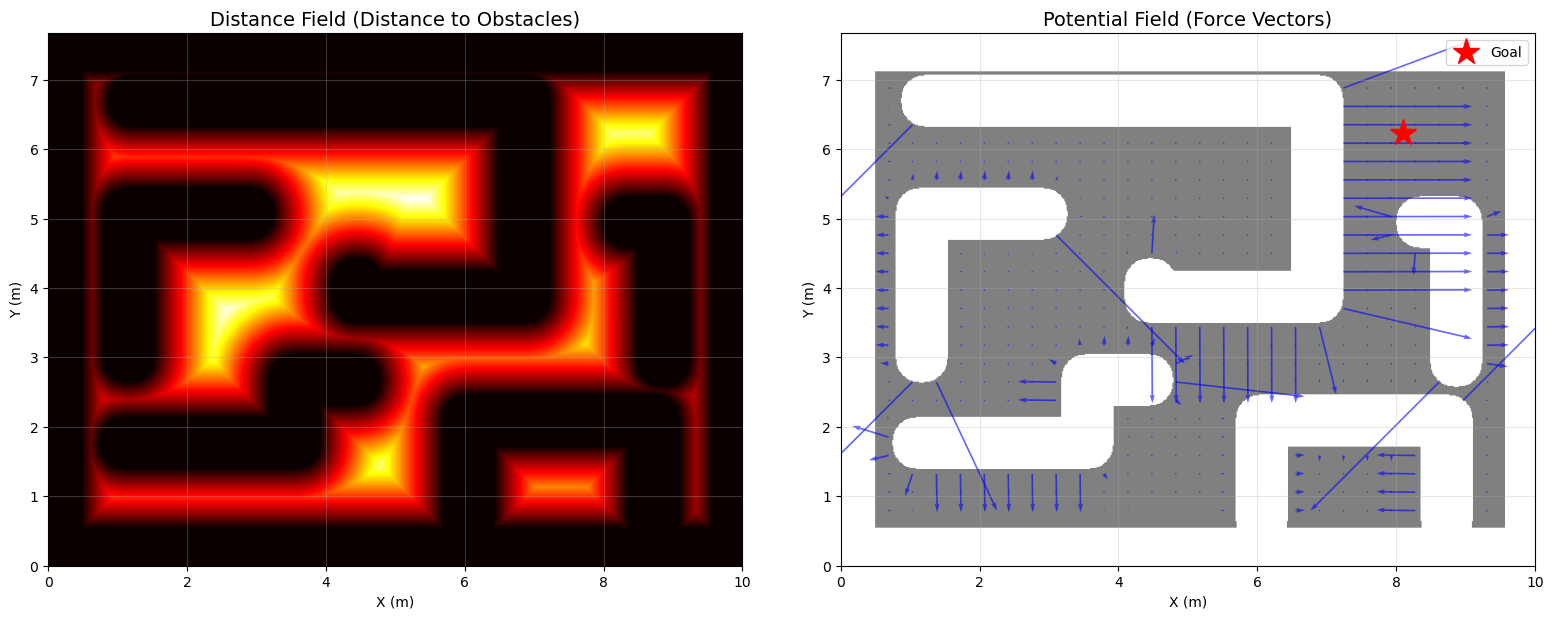

In [34]:
# Visualize potential field
planner_1.visualize_potential_field(goal_map_1, resolution=30)

C:\Users\danie\AppData\Local\Temp\ipykernel_42192\2474318275.py:49: RuntimeWarning: invalid value encountered in multiply
  F_rep_clipped[F_rep_mag > max_rep] *= (max_rep / F_rep_mag[F_rep_mag > max_rep, np.newaxis])
C:\Users\danie\AppData\Local\Temp\ipykernel_42192\2474318275.py:67: RuntimeWarning: invalid value encountered in multiply
  F_total_clipped[F_total_mag > max_total] *= (max_total / F_total_mag[F_total_mag > max_total, np.newaxis])


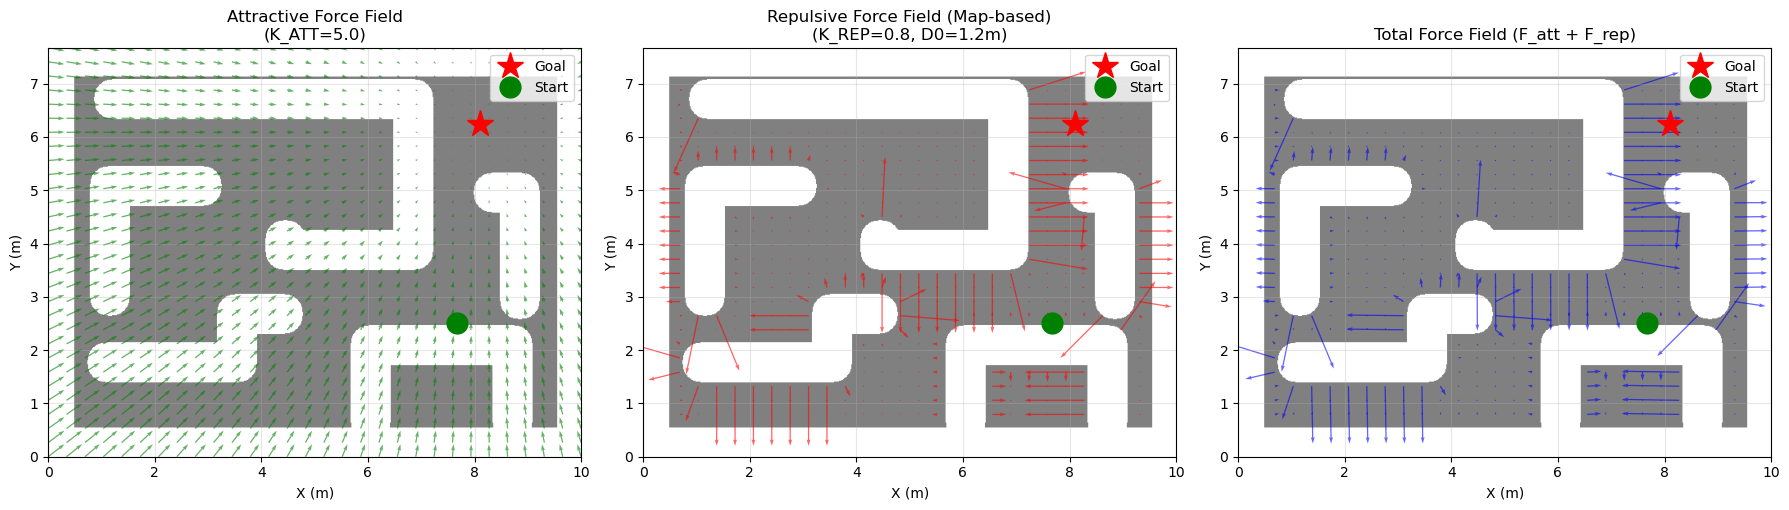

  - Mean magnitude: 24.53 N
  - Max magnitude: 51.12 N

Repulsive Forces:
  - Mean magnitude: nan N
  - Max magnitude: nan N

Force Ratio (F_rep/F_att): nanx


In [35]:
# Visualize Potential Field with Vector Field
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Grid for vector field visualization
resolution = 30
XX, YY = np.meshgrid(
    np.linspace(0, ACTUAL_TERRAIN_WIDTH, resolution),
    np.linspace(0, ACTUAL_TERRAIN_HEIGHT, resolution)
)
XY = np.dstack([XX, YY]).reshape(-1, 2)

# Calculate forces at each grid point
F_att_grid = []
F_rep_grid = []
F_total_grid = []

for point in XY:
    f_att = planner_1.attractive_force(point, np.array(goal_map_1))
    f_rep = planner_1.repulsive_force(point)
    F_att_grid.append(f_att)
    F_rep_grid.append(f_rep)
    F_total_grid.append(f_att + f_rep)

F_att_grid = np.array(F_att_grid)
F_rep_grid = np.array(F_rep_grid)
F_total_grid = np.array(F_total_grid)

# Plot 1: Attractive Forces
ax1 = axes[0]
ax1.imshow(mapa_1, cmap='gray', origin='lower',
          extent=[0, ACTUAL_TERRAIN_WIDTH, 0, ACTUAL_TERRAIN_HEIGHT], alpha=0.5)
ax1.quiver(XX, YY, F_att_grid[:,0], F_att_grid[:,1], color='g', alpha=0.6)
ax1.plot(goal_map_1[0], goal_map_1[1], 'r*', markersize=20, label='Goal')
ax1.plot(start_map_1[0], start_map_1[1], 'go', markersize=15, label='Start')
ax1.set_title(f'Attractive Force Field\n(K_ATT={K_ATT})')
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Repulsive Forces (clipped for visualization)
ax2 = axes[1]
ax2.imshow(mapa_1, cmap='gray', origin='lower',
          extent=[0, ACTUAL_TERRAIN_WIDTH, 0, ACTUAL_TERRAIN_HEIGHT], alpha=0.5)
# Clip repulsive forces for visualization
F_rep_clipped = F_rep_grid.copy()
F_rep_mag = np.linalg.norm(F_rep_clipped, axis=1)
max_rep = np.percentile(F_rep_mag[F_rep_mag > 0], 90) if np.any(F_rep_mag > 0) else 1.0
F_rep_clipped[F_rep_mag > max_rep] *= (max_rep / F_rep_mag[F_rep_mag > max_rep, np.newaxis])
ax2.quiver(XX, YY, F_rep_clipped[:,0], F_rep_clipped[:,1], color='r', alpha=0.6)
ax2.plot(goal_map_1[0], goal_map_1[1], 'r*', markersize=20, label='Goal')
ax2.plot(start_map_1[0], start_map_1[1], 'go', markersize=15, label='Start')
ax2.set_title(f'Repulsive Force Field (Map-based)\n(K_REP={K_REP}, D0={D0}m)')
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Total Forces (clipped for visualization)
ax3 = axes[2]
ax3.imshow(mapa_1, cmap='gray', origin='lower',
          extent=[0, ACTUAL_TERRAIN_WIDTH, 0, ACTUAL_TERRAIN_HEIGHT], alpha=0.5)
# Clip total forces for visualization
F_total_clipped = F_total_grid.copy()
F_total_mag = np.linalg.norm(F_total_clipped, axis=1)
max_total = np.percentile(F_total_mag[F_total_mag > 0], 90) if np.any(F_total_mag > 0) else 1.0
F_total_clipped[F_total_mag > max_total] *= (max_total / F_total_mag[F_total_mag > max_total, np.newaxis])
ax3.quiver(XX, YY, F_total_clipped[:,0], F_total_clipped[:,1], color='b', alpha=0.6)
ax3.plot(goal_map_1[0], goal_map_1[1], 'r*', markersize=20, label='Goal')
ax3.plot(start_map_1[0], start_map_1[1], 'go', markersize=15, label='Start')
ax3.set_title('Total Force Field (F_att + F_rep)')
ax3.set_xlabel('X (m)')
ax3.set_ylabel('Y (m)')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print force statistics
print(f"  - Mean magnitude: {np.mean(np.linalg.norm(F_att_grid, axis=1)):.2f} N")
print(f"  - Max magnitude: {np.max(np.linalg.norm(F_att_grid, axis=1)):.2f} N")
print(f"\nRepulsive Forces:")
print(f"  - Mean magnitude: {np.mean(np.linalg.norm(F_rep_grid, axis=1)):.2f} N")
print(f"  - Max magnitude: {np.max(np.linalg.norm(F_rep_grid, axis=1)):.2f} N")
print(f"\nForce Ratio (F_rep/F_att): {np.mean(np.linalg.norm(F_rep_grid, axis=1))/np.mean(np.linalg.norm(F_att_grid, axis=1)):.2f}x")

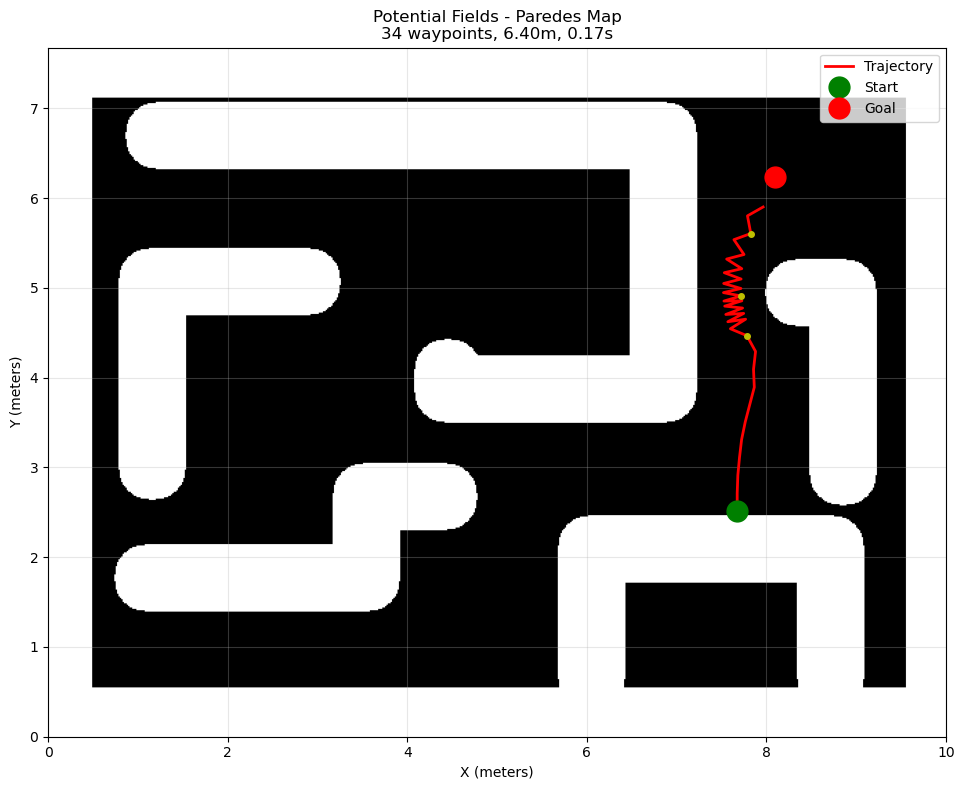

In [36]:
# Visualize trajectory on map
if trajectory_1 and len(trajectory_1) > 1:
    fig, ax = plt.subplots(figsize=(12, 8))

    # Show map
    ax.imshow(mapa_1, cmap='gray', origin='lower',
             extent=[0, ACTUAL_TERRAIN_WIDTH, 0, ACTUAL_TERRAIN_HEIGHT])

    # Draw trajectory
    path_x = [p[0] for p in trajectory_1]
    path_y = [p[1] for p in trajectory_1]
    ax.plot(path_x, path_y, 'r-', linewidth=2, label='Trajectory')
    ax.plot(path_x[::10], path_y[::10], 'yo', markersize=4)  # Sample points

    # Mark start and goal
    ax.plot(start_map_1[0], start_map_1[1], 'go', markersize=15, label='Start')
    ax.plot(goal_map_1[0], goal_map_1[1], 'ro', markersize=15, label='Goal')

    ax.set_xlim(0, ACTUAL_TERRAIN_WIDTH)
    ax.set_ylim(0, ACTUAL_TERRAIN_HEIGHT)
    ax.set_xlabel('X (meters)')
    ax.set_ylabel('Y (meters)')
    ax.set_title(f'Potential Fields - Paredes Map\n{len(trajectory_1)} waypoints, {path_length_1:.2f}m, {elapsed_time_1:.2f}s')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 8. Executar caminho de maneira REATIVA com Pioneer P3DX



REACTIVE POTENTIAL FIELDS NAVIGATION - PAREDES MAP
K_ATT=5.0, K_REP=0.8, D0=1.2m
Control rate: 0.1s
Max velocities: v=0.5m/s, omega=1.0rad/s



Goal reached after 31 iterations
Final distance: 0.494 m


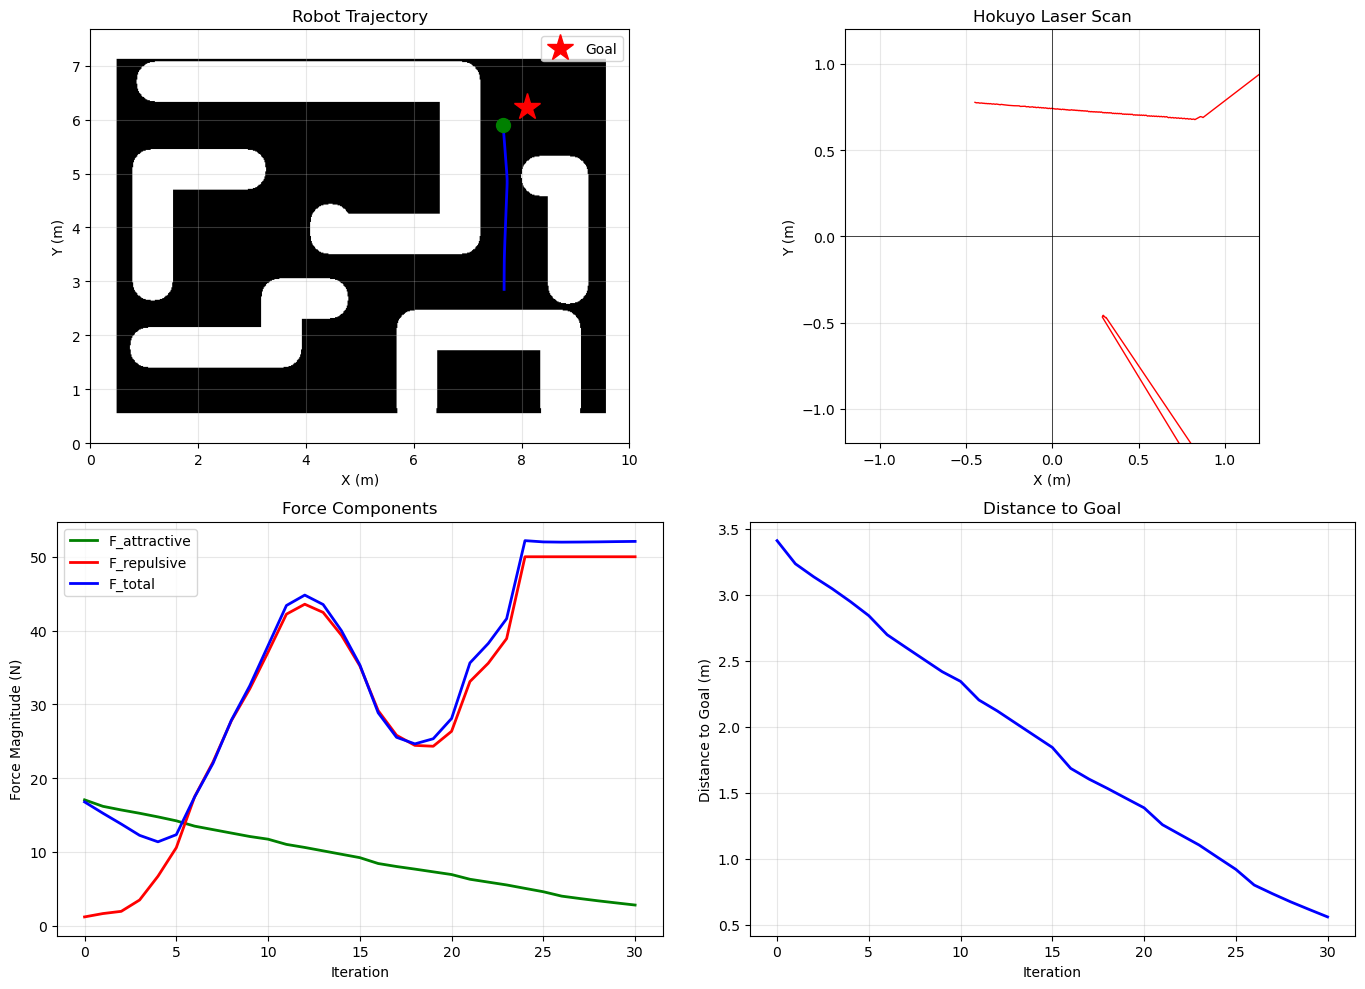

Iterations: 32
Execution time: 11.86 s
Path length: 3.20 m
Final position: (2.62, 2.53)
Final orientation: 94.5 deg
Final error: 6.614 m

Force Statistics:
Average F_att: 9.33 N
Average F_rep: 30.73 N
Max F_rep: 50.00 N
Force ratio (F_rep/F_att): 3.29

Simulation stopped

Simulation stopped


In [37]:
# Execute REACTIVE SENSOR-BASED NAVIGATION
print("REACTIVE POTENTIAL FIELDS NAVIGATION - PAREDES MAP")
print(f"K_ATT={K_ATT}, K_REP={K_REP}, D0={D0}m")
print(f"Control rate: {CONTROL_RATE}s")
print(f"Max velocities: v={MAX_LINEAR_VEL}m/s, omega={MAX_ANGULAR_VEL}rad/s")

# Start simulation
controller.start_simulation()
time.sleep(0.5)

# Setup real-time visualization
plt.ion()
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax_map = axes[0, 0]
ax_laser = axes[0, 1]
ax_forces = axes[1, 0]
ax_distance = axes[1, 1]

# Map with trajectory
ax_map.imshow(mapa_1, cmap='gray', origin='lower',
             extent=[0, ACTUAL_TERRAIN_WIDTH, 0, ACTUAL_TERRAIN_HEIGHT])
ax_map.plot(goal_map_1[0], goal_map_1[1], 'r*', markersize=20, label='Goal')
ax_map.set_title('Robot Trajectory')
ax_map.set_xlabel('X (m)')
ax_map.set_ylabel('Y (m)')
ax_map.legend()
ax_map.grid(True, alpha=0.3)

trajectory_line, = ax_map.plot([], [], 'b-', linewidth=2)
robot_marker, = ax_map.plot([], [], 'go', markersize=10)

# Laser scan visualization
laser_lines, = ax_laser.plot([], [], 'r-', linewidth=1)
ax_laser.set_xlim(-D0, D0)
ax_laser.set_ylim(-D0, D0)
ax_laser.set_aspect('equal')
ax_laser.set_title('Hokuyo Laser Scan')
ax_laser.set_xlabel('X (m)')
ax_laser.set_ylabel('Y (m)')
ax_laser.grid(True, alpha=0.3)
ax_laser.axhline(0, color='k', linewidth=0.5)
ax_laser.axvline(0, color='k', linewidth=0.5)

# Force history
force_att_line, = ax_forces.plot([], [], 'g-', linewidth=2, label='F_attractive')
force_rep_line, = ax_forces.plot([], [], 'r-', linewidth=2, label='F_repulsive')
force_total_line, = ax_forces.plot([], [], 'b-', linewidth=2, label='F_total')
ax_forces.set_xlabel('Iteration')
ax_forces.set_ylabel('Force Magnitude (N)')
ax_forces.set_title('Force Components')
ax_forces.legend()
ax_forces.grid(True, alpha=0.3)

# Distance to goal
distance_line, = ax_distance.plot([], [], 'b-', linewidth=2)
ax_distance.set_xlabel('Iteration')
ax_distance.set_ylabel('Distance to Goal (m)')
ax_distance.set_title('Distance to Goal')
ax_distance.grid(True, alpha=0.3)

plt.tight_layout()

try:
    d = 0.5  # Desai controller parameter
    max_exec_iterations = 500

    actual_trajectory = []
    force_att_history = []
    force_rep_history = []
    force_total_history = []
    distance_history = []
    execution_start_time = time.time()

    for iteration in range(max_exec_iterations):
        # Get current state
        robot_x_curr, robot_y_curr, robot_theta_curr = controller.get_robot_pose_2d()
        robot_map_curr = sim_to_map(robot_x_curr, robot_y_curr, ACTUAL_TERRAIN_HEIGHT)
        actual_trajectory.append(robot_map_curr)

        # Check goal reached
        distance_to_goal = np.sqrt(
            (robot_map_curr[0] - goal_map_1[0])**2 +
            (robot_map_curr[1] - goal_map_1[1])**2
        )
        distance_history.append(distance_to_goal)

        if distance_to_goal < GOAL_THRESHOLD:
            print(f"\nGoal reached after {iteration} iterations")
            print(f"Final distance: {distance_to_goal:.3f} m")
            break

        # REACTIVE SENSOR-BASED FORCE COMPUTATION
        laser_data = controller.get_laser_data()

        if laser_data is not None:
            # Compute repulsive force from sensor (robot frame)
            f_rep_local = controller.compute_repulsive_force_from_laser(laser_data, K_REP, D0)

            # Transform to world frame
            cos_theta = np.cos(robot_theta_curr)
            sin_theta = np.sin(robot_theta_curr)
            f_rep_world = np.array([
                cos_theta * f_rep_local[0] - sin_theta * f_rep_local[1],
                sin_theta * f_rep_local[0] + cos_theta * f_rep_local[1]
            ])
        else:
            f_rep_world = np.array([0.0, 0.0])

        # Attractive force (world frame)
        current_pos = np.array([robot_map_curr[0], robot_map_curr[1]])
        goal_pos = np.array([goal_map_1[0], goal_map_1[1]])
        f_att = K_ATT * (goal_pos - current_pos)

        # Total force
        f_total = f_att + f_rep_world
        force_magnitude = np.linalg.norm(f_total)

        # Store force history
        force_att_history.append(np.linalg.norm(f_att))
        force_rep_history.append(np.linalg.norm(f_rep_world))
        force_total_history.append(force_magnitude)

        # Check for very small force (local minimum)
        if force_magnitude < 1e-3:
            print(f"\nWarning: Very small force at iteration {iteration}")
            print(f"Position: ({robot_map_curr[0]:.2f}, {robot_map_curr[1]:.2f})")
            print(f"Distance to goal: {distance_to_goal:.2f} m")
            # Add small perturbation
            f_total = f_total + np.random.randn(2) * 0.1
            force_magnitude = np.linalg.norm(f_total)

        # Compute desired velocity
        if force_magnitude > 1e-6:
            desired_velocity = (f_total / force_magnitude) * MAX_LINEAR_VEL * 0.5
        else:
            desired_velocity = np.array([0.0, 0.0])

        x_dot = desired_velocity[0]
        y_dot = desired_velocity[1]

        # Desai et al. 1998 velocity transformation
        v = cos_theta * x_dot + sin_theta * y_dot
        omega = (-sin_theta / d) * x_dot + (cos_theta / d) * y_dot

        # Limit velocities
        v = np.clip(v, -MAX_LINEAR_VEL, MAX_LINEAR_VEL)
        omega = np.clip(omega, -MAX_ANGULAR_VEL, MAX_ANGULAR_VEL)

        # Apply velocities
        controller.set_velocities(v, omega)

        # Update visualization every 5 iterations
        if iteration % 5 == 0 and laser_data is not None:
            traj_x = [p[0] for p in actual_trajectory]
            traj_y = [p[1] for p in actual_trajectory]
            trajectory_line.set_data(traj_x, traj_y)
            robot_marker.set_data([robot_map_curr[0]], [robot_map_curr[1]])

            laser_x = laser_data[:, 1] * np.cos(laser_data[:, 0])
            laser_y = laser_data[:, 1] * np.sin(laser_data[:, 0])
            laser_lines.set_data(laser_x, laser_y)

            iterations = list(range(len(force_att_history)))
            force_att_line.set_data(iterations, force_att_history)
            force_rep_line.set_data(iterations, force_rep_history)
            force_total_line.set_data(iterations, force_total_history)
            ax_forces.relim()
            ax_forces.autoscale_view()

            distance_line.set_data(iterations, distance_history)
            ax_distance.relim()
            ax_distance.autoscale_view()

            fig.canvas.draw()
            fig.canvas.flush_events()

        # Progress update
        if (iteration + 1) % 50 == 0:
            print(f"Iteration {iteration+1}: dist={distance_to_goal:.2f}m, "
                  f"F_att={force_att_history[-1]:.2f}N, F_rep={force_rep_history[-1]:.2f}N")

        time.sleep(CONTROL_RATE)

    # Stop robot
    controller.stop()
    time.sleep(0.5)

    plt.ioff()
    plt.show()

    # Calculate metrics
    execution_time = time.time() - execution_start_time

    if len(actual_trajectory) > 1:
        trajectory_array = np.array(actual_trajectory)
        actual_path_length = np.sum(np.sqrt(np.sum(np.diff(trajectory_array, axis=0)**2, axis=1)))
    else:
        actual_path_length = 0.0

    final_x, final_y, final_theta = controller.get_robot_pose_2d()
    final_error = np.sqrt((final_x - goal_pos[0])**2 + (final_y - goal_pos[1])**2)

    print(f"Iterations: {min(iteration + 1, max_exec_iterations)}")
    print(f"Execution time: {execution_time:.2f} s")
    print(f"Path length: {actual_path_length:.2f} m")
    print(f"Final position: ({final_x:.2f}, {final_y:.2f})")
    print(f"Final orientation: {np.degrees(final_theta):.1f} deg")
    print(f"Final error: {final_error:.3f} m")
    print(f"\nForce Statistics:")
    print(f"Average F_att: {np.mean(force_att_history):.2f} N")
    print(f"Average F_rep: {np.mean(force_rep_history):.2f} N")
    print(f"Max F_rep: {np.max(force_rep_history):.2f} N")
    print(f"Force ratio (F_rep/F_att): {np.mean(force_rep_history)/np.mean(force_att_history):.2f}")

    trajectory_1 = actual_trajectory
    path_length_1 = actual_path_length
    elapsed_time_1 = execution_time

    if distance_to_goal >= GOAL_THRESHOLD:
        print(f"\nLocal minimum encountered (known limitation of Potential Fields)")

except Exception as e:
    print(f"\nError during execution: {e}")
    import traceback
    traceback.print_exc()
    controller.stop()

finally:
    controller.stop_simulation()
    print("\nSimulation stopped")

---

# Experimento 2: Cave Map

Testando a mesma implementação de Potential Fields com um ambiente diferente, *cave-robotino*


In [38]:
print("\n" + "="*60)
print("Experiment 2 - Abra Cave Map,  cave-pioneer.ttt")

print("="*60)

wait_for_user_input("Pressione Enter após abrir Cave Map (cave-pioneer)...")


Experiment 2 - Abra Cave Map,  cave-pioneer.ttt


In [39]:
controller = PioneerController()
if not controller.connect():
    raise Exception("Failed to connect")
if not controller.initialize_scene():
    raise Exception("Failed to initialize")


✓ Connected to CoppeliaSim
✓ Found robot: PioneerP3DX
✓ Found motors: leftMotor, rightMotor
✓ Initialized Hokuyo laser sensor
✓ Found goal at: (1.62, 4.02)


In [40]:
try:
    all_objects_2 = controller.sim.getObjectsInTree(controller.sim.handle_scene, controller.sim.object_shape_type, 0)

    terrain_found = False
    for obj_handle in all_objects_2:
        try:
            obj_name = controller.sim.getObjectAlias(obj_handle)
            if 'terrain' in obj_name.lower() or 'heightfield' in obj_name.lower():
                min_x_2 = controller.sim.getObjectFloatParam(obj_handle, controller.sim.objfloatparam_objbbox_min_x)
                max_x_2 = controller.sim.getObjectFloatParam(obj_handle, controller.sim.objfloatparam_objbbox_max_x)
                min_y_2 = controller.sim.getObjectFloatParam(obj_handle, controller.sim.objfloatparam_objbbox_min_y)
                max_y_2 = controller.sim.getObjectFloatParam(obj_handle, controller.sim.objfloatparam_objbbox_max_y)

                terrain_width_2 = max_x_2 - min_x_2
                terrain_height_2 = max_y_2 - min_y_2

                print(f"✓ Detected {obj_name}: {terrain_width_2:.2f}m × {terrain_height_2:.2f}m")
                terrain_found = True
                break
        except:
            continue

    if not terrain_found:
        terrain_width_2 = 10.0
        terrain_height_2 = 10.0
        print(f"No terrain detected, using default: {terrain_width_2:.2f}m × {terrain_height_2:.2f}m")

except Exception as e:
    terrain_width_2 = 10.0
    terrain_height_2 = 10.0
    print(f"Using default: {terrain_width_2:.2f}m × {terrain_height_2:.2f}m")

# Get robot pose
robot_x_2, robot_y_2, robot_theta_2 = controller.get_robot_pose_2d()
robot_map_x_2, robot_map_y_2 = sim_to_map(robot_x_2, robot_y_2, terrain_height_2)

print(f"\nExperiment 2 - Robot Status:")
print(f"Position (CoppeliaSim): ({robot_x_2:.2f}, {robot_y_2:.2f})")
print(f"Orientation: {np.degrees(robot_theta_2):.1f}°")
print(f"Position (Map frame): ({robot_map_x_2:.2f}, {robot_map_y_2:.2f})")

# Get goal
goal_pos_2 = controller.get_goal_position()
if goal_pos_2:
    goal_map_x_2, goal_map_y_2 = sim_to_map(goal_pos_2[0], goal_pos_2[1], terrain_height_2)
    print(f"\nGoal Position:")
    print(f"Position (CoppeliaSim): ({goal_pos_2[0]:.2f}, {goal_pos_2[1]:.2f})")
    print(f"Position (Map frame): ({goal_map_x_2:.2f}, {goal_map_y_2:.2f})")
else:
    raise Exception("Goal not found!")

✓ Detected Terrain_Heightfield: 10.00m × 10.00m

Experiment 2 - Robot Status:
Position (CoppeliaSim): (-1.02, -4.65)
Orientation: 135.0°
Position (Map frame): (3.98, 0.35)

Goal Position:
Position (CoppeliaSim): (1.62, 4.02)
Position (Map frame): (6.62, 9.03)


Cave Map loaded: (500, 500) pixels
- Physical size: 10.0m x 10.0m
- Cave safety margin: 0.300m (2x standard)
- Cave effective radius: 0.500m
- C-space dilation: 24 pixels (0.500m)


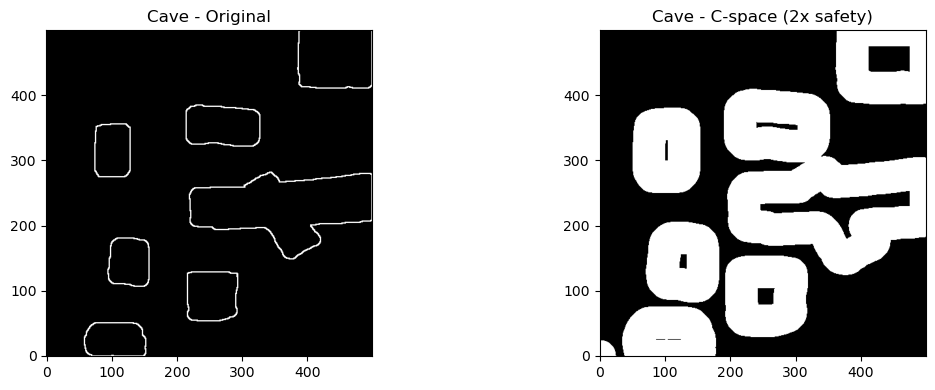

In [41]:
# Load cave map
map_path_2 = "mapas/cave.png"
mapa_img_2 = Image.open(map_path_2).convert('L')
mapa_raw_2 = np.array(mapa_img_2)

# Normalize
mapa_original_2 = 1.0 - (mapa_raw_2 / 255.0)

# Apply C-space transformation with 2x safety margin for cave
# Cave environment: Use double safety margin (0.30m instead of 0.15m)
CAVE_SAFETY_MARGIN = SAFETY_MARGIN * 2.0  # 0.30m (2x larger for cave)
CAVE_EFFECTIVE_RADIUS = ROBOT_RADIUS + CAVE_SAFETY_MARGIN  # 0.50m total

# C-space dilation with cave-specific effective radius
radius_pixels_2 = int((CAVE_EFFECTIVE_RADIUS / terrain_width_2) * mapa_original_2.shape[1])
y2, x2 = np.ogrid[-radius_pixels_2:radius_pixels_2+1, -radius_pixels_2:radius_pixels_2+1]
structure_2 = (x2**2 + y2**2 <= radius_pixels_2**2).astype(int)
mapa_2 = binary_dilation(mapa_original_2 > 0.5, structure=structure_2).astype(float)

print(f"Cave Map loaded: {mapa_2.shape} pixels")
print(f"- Physical size: {terrain_width_2:.1f}m x {terrain_height_2:.1f}m")
print(f"- Cave safety margin: {CAVE_SAFETY_MARGIN:.3f}m (2x standard)")
print(f"- Cave effective radius: {CAVE_EFFECTIVE_RADIUS:.3f}m")
print(f"- C-space dilation: {radius_pixels_2} pixels ({CAVE_EFFECTIVE_RADIUS:.3f}m)")

# Visualize
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(mapa_original_2, cmap='gray', origin='lower')
plt.title('Cave - Original')
plt.subplot(1, 2, 2)
plt.imshow(mapa_2, cmap='gray', origin='lower')
plt.title('Cave - C-space (2x safety)')
plt.tight_layout()
plt.show()

## Executando Reactive Potential Fields


In [42]:
# Display initial state
print(f"\nInitial State:")
print(f"  Robot: ({robot_map_x_2:.2f}, {robot_map_y_2:.2f}) in map frame")
print(f"  Goal:  ({goal_map_x_2:.2f}, {goal_map_y_2:.2f}) in map frame")
initial_dist = np.linalg.norm(np.array([goal_map_x_2, goal_map_y_2]) - np.array([robot_map_x_2, robot_map_y_2]))
print(f"  Initial distance: {initial_dist:.2f} m")
print(f"  Goal threshold: {GOAL_THRESHOLD:.2f} m")

# Display algorithm parameters
print(f"\nParameters:")
print(f"  K_ATT = {K_ATT} (Attractive force gain)")
print(f"  K_REP = {K_REP} (Repulsive force gain)")
print(f"  D0 = {D0} m (Obstacle influence distance)")
print(f"  Max iterations: 500")
print(f"  Control rate: {CONTROL_RATE} s")



Initial State:
  Robot: (3.98, 0.35) in map frame
  Goal:  (6.62, 9.03) in map frame
  Initial distance: 9.07 m
  Goal threshold: 0.50 m

Parameters:
  K_ATT = 5.0 (Attractive force gain)
  K_REP = 0.8 (Repulsive force gain)
  D0 = 1.2 m (Obstacle influence distance)
  Max iterations: 500
  Control rate: 0.1 s


In [48]:
fig_cave, axes_cave = plt.subplots(2, 2, figsize=(12, 10))
ax_traj = axes_cave[0, 0]      # Trajectory plot
ax_laser = axes_cave[0, 1]     # Laser scan plot
ax_forces = axes_cave[1, 0]    # Force history plot
ax_dist = axes_cave[1, 1]      # Distance history plot

# Initialize trajectory storage
trajectory_cave = []
force_att_history = []
force_rep_history = []
distance_history = []

# ============================================================================
# CONTROL PARAMETERS
# ============================================================================
d = 0.5  # Look-ahead distance for Desai controller (meters)
max_iterations = 150  # Maximum iterations for this experiment


In [44]:
controller.start_simulation()


In [45]:
print(f"\nStarting navigation loop (max {max_iterations} iterations)...")

# ============================================================================
# MAIN NAVIGATION LOOP
# ============================================================================
try:
    for iteration in range(max_iterations):
        # --------------------------------------------------------------------
        # 1. GET CURRENT ROBOT STATE
        # --------------------------------------------------------------------
        # Query robot position (x, y) and orientation (theta) from CoppeliaSim
        robot_x, robot_y, robot_theta = controller.get_robot_pose_2d()

        # Transform from CoppeliaSim coordinates to map coordinates
        robot_map_pos = sim_to_map(robot_x, robot_y, terrain_height_2)
        trajectory_cave.append(robot_map_pos)

        # --------------------------------------------------------------------
        # 2. CHECK GOAL REACHED
        # --------------------------------------------------------------------
        # Calculate Euclidean distance from current position to goal
        dist = np.linalg.norm(np.array([goal_map_x_2, goal_map_y_2]) - np.array(robot_map_pos))
        distance_history.append(dist)

        # Goal reached condition: distance below threshold
        if dist < GOAL_THRESHOLD:
            print(f"\n{'='*70}")
            print(f"  GOAL REACHED at iteration {iteration}!")
            print(f"  Final distance: {dist:.3f} m (threshold: {GOAL_THRESHOLD} m)")
            print(f"  Final position: ({robot_map_pos[0]:.2f}, {robot_map_pos[1]:.2f})")
            print(f"{'='*70}")
            break

        # --------------------------------------------------------------------
        # 3. READ LASER SENSOR DATA (REAL-TIME OBSTACLE DETECTION)
        # --------------------------------------------------------------------
        # Get laser readings from Hokuyo sensor (684 points, 240° FOV, 5m range)
        # Returns: array of [angle, distance] pairs in robot's local frame
        laser_data = controller.get_laser_data()

        # POTENTIAL FIELDS ALGORITHM

        # 4. COMPUTE REPULSIVE FORCE FROM OBSTACLES (SENSOR-BASED)
        if laser_data is not None:
            # Compute repulsive force from laser readings in robot's local frame
            # This implements: F_rep = K_REP * sum_i[(1/d_i - 1/D0) * (1/d_i^2) * unit_vector_i]
            # where d_i is distance to obstacle i, D0 is influence distance
            f_rep_local = controller.compute_repulsive_force_from_laser(laser_data, K_REP, D0)

            # Transform repulsive force from robot frame to world frame
            # Rotation matrix: R(θ) = [cos(θ) -sin(θ); sin(θ) cos(θ)]
            cos_th = np.cos(robot_theta)
            sin_th = np.sin(robot_theta)
            f_rep = np.array([
                cos_th * f_rep_local[0] - sin_th * f_rep_local[1],  # World X component
                sin_th * f_rep_local[0] + cos_th * f_rep_local[1]   # World Y component
            ])
        else:
            # No laser data available - assume no obstacles nearby
            print("No laser data available - assume no obstacles nearby")
            f_rep = np.array([0.0, 0.0])

        # --------------------------------------------------------------------
        # 5. COMPUTE ATTRACTIVE FORCE TO GOAL
        # --------------------------------------------------------------------
        # Attractive force pulls robot toward goal
        # Implementation: F_att = K_ATT * (goal_position - robot_position)
        # This creates a linear potential field centered at the goal
        f_att = K_ATT * (np.array([goal_map_x_2, goal_map_y_2]) - np.array(robot_map_pos))

        # --------------------------------------------------------------------
        # 6. COMPUTE TOTAL FORCE (SUPERPOSITION PRINCIPLE)
        # --------------------------------------------------------------------
        # Total force is the sum of attractive and repulsive forces
        # F_total = F_attractive + F_repulsive
        f_total = f_att + f_rep

        # Store force magnitudes for analysis and visualization
        force_att_history.append(np.linalg.norm(f_att))
        force_rep_history.append(np.linalg.norm(f_rep))

        # POTENTIAL FIELDS ALGORITHM

        # 7. TRANSFORM FORCES TO DESIRED VELOCITIES
        # Scale total force to desired Cartesian velocity
        # Scaling factor 0.1 converts force magnitude to reasonable velocity
        x_dot = f_total[0] * 0.1  # Desired velocity in world X direction
        y_dot = f_total[1] * 0.1  # Desired velocity in world Y direction

        # 8. APPLY DESAI CONTROLLER
        # Transform desired Cartesian velocities (ẋ, ẏ) to robot velocities (v, ω)
        # where θ is robot orientation, d is look-ahead distance

        # Linear velocity: project desired velocity onto robot's heading
        v = cos_th * x_dot + sin_th * y_dot

        # Angular velocity: rotational component to align with desired direction
        omega = (-sin_th / d) * x_dot + (cos_th / d) * y_dot

        # 9. LIMIT VELOCITIES TO SAFE RANGES
        # Clip velocities to prevent exceeding robot's physical limits
        v = np.clip(v, -MAX_LINEAR_VEL, MAX_LINEAR_VEL)      # Linear: ±0.5 m/s
        omega = np.clip(omega, -MAX_ANGULAR_VEL, MAX_ANGULAR_VEL)  # Angular: ±1.0 rad/s

        # 10. SEND VELOCITIES TO ROBOT
        # Apply computed velocities to robot's wheels via CoppeliaSim API
        controller.set_velocities(v, omega)

        if iteration % 10 == 0:
            print(f"\nIteration {iteration}:")
            print(f"  Position: ({robot_map_pos[0]:.2f}, {robot_map_pos[1]:.2f})")
            print(f"  Distance to goal: {dist:.3f} m")
            print(f"  F_attractive: {np.linalg.norm(f_att):.2f} N")
            print(f"  F_repulsive: {np.linalg.norm(f_rep):.2f} N")
            print(f"  Velocities: v={v:.3f} m/s, ω={omega:.3f} rad/s")
            if laser_data is not None:
                min_dist = np.min(laser_data[:, 1])
                print(f"  Laser: {len(laser_data)} points, min distance: {min_dist:.3f} m")

        # Control loop timing (10 Hz = 0.1s period)
        time.sleep(CONTROL_RATE)

    # Stop robot motion after navigation completes
    controller.stop()
    print(f"\nNavigation completed at iteration {iteration}")

except KeyboardInterrupt:
    print("\nNavigation interrupted by user")
    controller.stop()
except Exception as e:
    print(f"\nError during navigation: {e}")
    import traceback
    traceback.print_exc()
    controller.stop()

finally:
    # Ensure simulation is stopped regardless of how loop exits
    controller.stop_simulation()
    time.sleep(0.3)



Starting navigation loop (max 150 iterations)...

Iteration 0:
  Position: (3.85, 0.48)
  Distance to goal: 8.982 m
  F_attractive: 44.91 N
  F_repulsive: 50.00 N
  Velocities: v=0.500 m/s, ω=-1.000 rad/s
  Laser: 684 points, min distance: 0.538 m

Iteration 0:
  Position: (3.85, 0.48)
  Distance to goal: 8.982 m
  F_attractive: 44.91 N
  F_repulsive: 50.00 N
  Velocities: v=0.500 m/s, ω=-1.000 rad/s
  Laser: 684 points, min distance: 0.538 m

Iteration 10:
  Position: (3.45, 1.22)
  Distance to goal: 8.431 m
  F_attractive: 42.16 N
  F_repulsive: 17.80 N
  Velocities: v=0.500 m/s, ω=-1.000 rad/s
  Laser: 684 points, min distance: 0.623 m

Iteration 10:
  Position: (3.45, 1.22)
  Distance to goal: 8.431 m
  F_attractive: 42.16 N
  F_repulsive: 17.80 N
  Velocities: v=0.500 m/s, ω=-1.000 rad/s
  Laser: 684 points, min distance: 0.623 m

Iteration 20:
  Position: (3.42, 1.81)
  Distance to goal: 7.895 m
  F_attractive: 39.48 N
  F_repulsive: 50.00 N
  Velocities: v=0.500 m/s, ω=-1.000 r

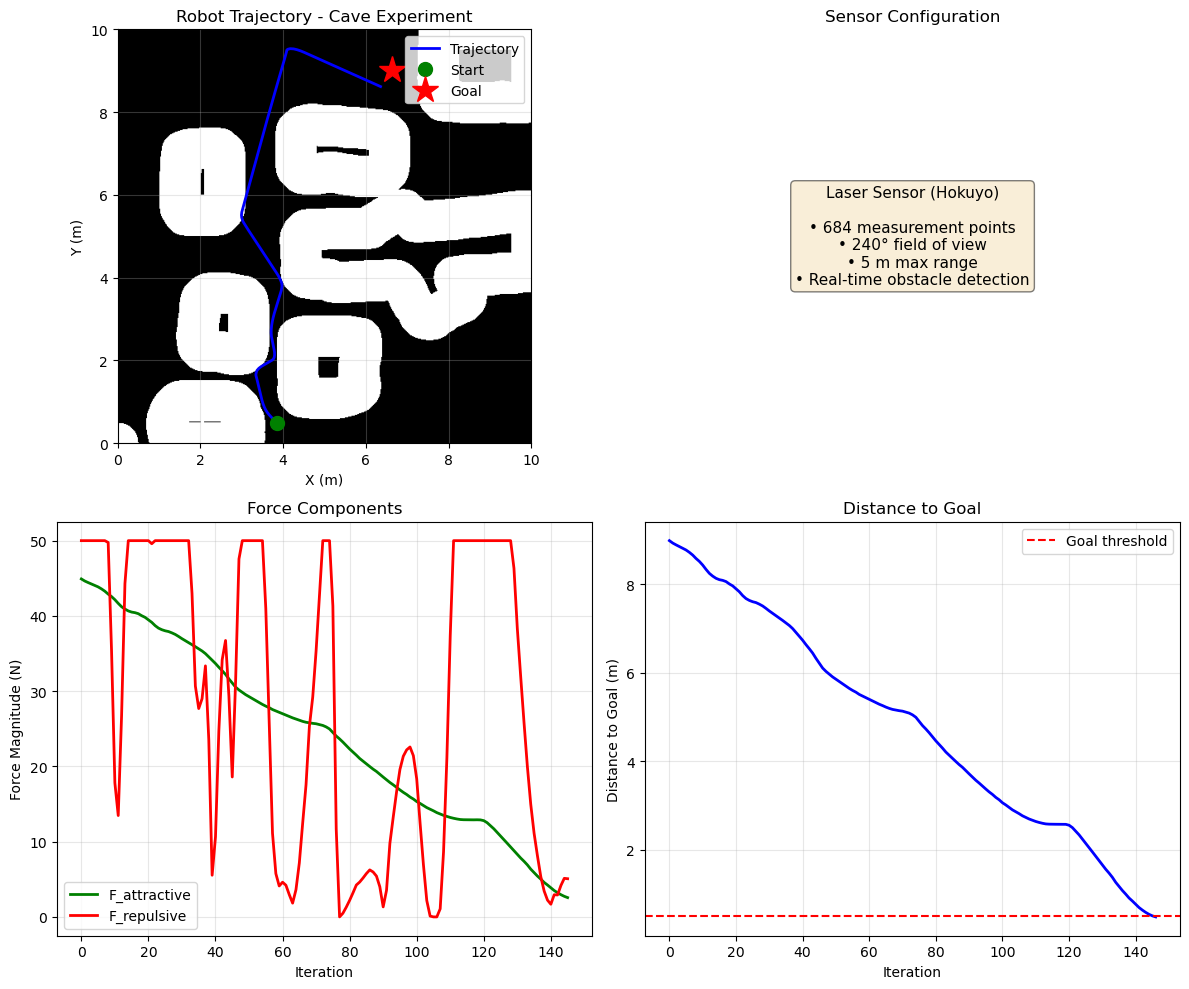


EXPERIMENT 2 - RESULTS SUMMARY
Status: GOAL REACHED

Navigation Metrics:
  Total iterations: 147
  Final distance to goal: 0.489 m
  Final position: (6.35, 8.62)
  Path length: 12.30 m

Force Statistics:
  Average F_attractive: 24.16 N
  Average F_repulsive: 28.97 N
  Max F_repulsive: 50.00 N
  Force balance (F_rep/F_att): 1.20


In [ ]:
# Plot 1: Robot Trajectory on Map
ax_traj.imshow(mapa_2, cmap='gray', origin='lower',
              extent=[0, terrain_width_2, 0, terrain_height_2])
if len(trajectory_cave) > 0:
    traj_arr = np.array(trajectory_cave)
    ax_traj.plot(traj_arr[:, 0], traj_arr[:, 1], 'b-', linewidth=2, label='Trajectory')
    ax_traj.plot(traj_arr[0, 0], traj_arr[0, 1], 'go', markersize=10, label='Start')
ax_traj.plot(goal_map_x_2, goal_map_y_2, 'r*', markersize=20, label='Goal')
ax_traj.set_title('Robot Trajectory - Cave Experiment')
ax_traj.set_xlabel('X (m)')
ax_traj.set_ylabel('Y (m)')
ax_traj.legend()
ax_traj.grid(True, alpha=0.3)

# Plot 2: Force Components Over Time
if len(force_att_history) > 0:
    iters = list(range(len(force_att_history)))
    ax_forces.plot(iters, force_att_history, 'g-', linewidth=2, label='F_attractive')
    ax_forces.plot(iters, force_rep_history, 'r-', linewidth=2, label='F_repulsive')
    ax_forces.set_xlabel('Iteration')
    ax_forces.set_ylabel('Force Magnitude (N)')
    ax_forces.set_title('Force Components')
    ax_forces.legend()
    ax_forces.grid(True, alpha=0.3)

# Plot 3: Distance to Goal Over Time
if len(distance_history) > 0:
    ax_dist.plot(distance_history, 'b-', linewidth=2)
    ax_dist.axhline(y=GOAL_THRESHOLD, color='r', linestyle='--', label='Goal threshold')
    ax_dist.set_xlabel('Iteration')
    ax_dist.set_ylabel('Distance to Goal (m)')
    ax_dist.set_title('Distance to Goal')
    ax_dist.legend()
    ax_dist.grid(True, alpha=0.3)

# Plot 4: Laser Sensor Information
ax_laser.text(0.5, 0.5, 'Laser Sensor (Hokuyo)\n\n' +
              '• 684 measurement points\n' +
              '• 240° field of view\n' +
              '• 5 m max range\n' +
              '• Real-time obstacle detection',
              ha='center', va='center', fontsize=11,
              bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax_laser.set_title('Sensor Configuration')
ax_laser.axis('off')

plt.tight_layout()
plt.show()

if dist < GOAL_THRESHOLD:
    print(f"Status: GOAL REACHED")
else:
    print(f"Status: Local minimum encountered (expected behavior)")

print(f"  Total iterations: {min(iteration + 1, max_iterations)}")
print(f"  Final distance to goal: {dist:.3f} m")
print(f"  Final position: ({robot_map_pos[0]:.2f}, {robot_map_pos[1]:.2f})")

if len(trajectory_cave) > 1:
    traj_length = np.sum(np.sqrt(np.sum(np.diff(traj_arr, axis=0)**2, axis=1)))
    print(f"  Path length: {traj_length:.2f} m")

if len(force_att_history) > 0:
    print(f"  Average F_attractive: {np.mean(force_att_history):.2f} N")
    print(f"  Average F_repulsive: {np.mean(force_rep_history):.2f} N")
    print(f"  Max F_repulsive: {np.max(force_rep_history):.2f} N")
    if np.mean(force_att_history) > 0:
        ratio = np.mean(force_rep_history) / np.mean(force_att_history)
        print(f"  Force balance (F_rep/F_att): {ratio:.2f}")


In [47]:
# Disconnect
controller.disconnect()